In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 3


# Train model 

In [107]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 5s 11us/step - loss: 0.0097 - acc: 0.9980 - val_loss: 0.0098 - val_acc: 0.9979


# Learning curves

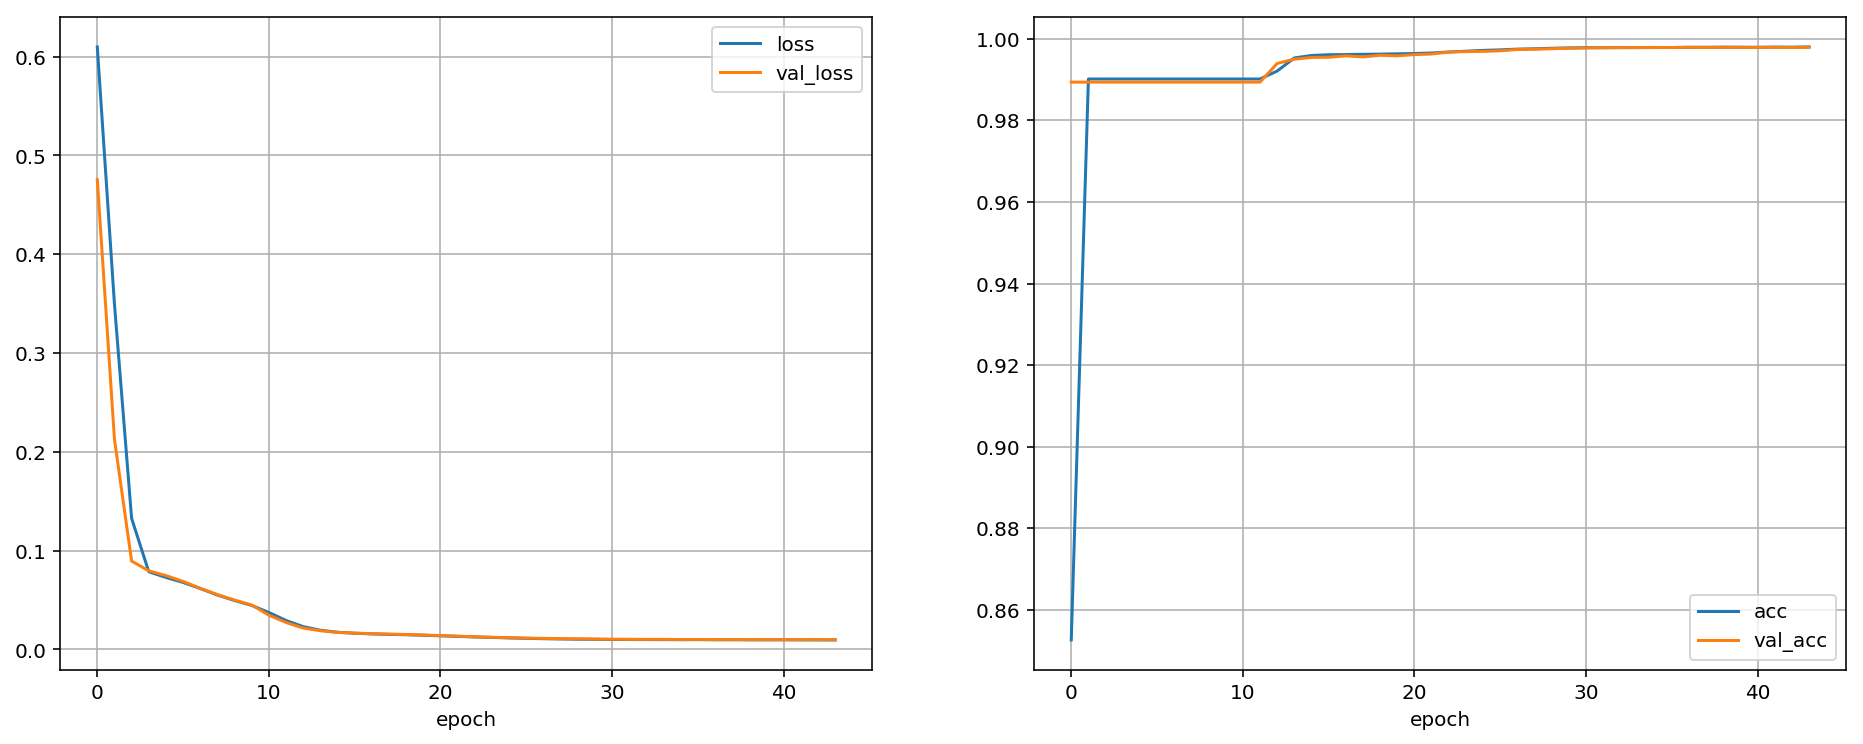

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [110]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53429
          1       0.97      0.83      0.89       575

avg / total       1.00      1.00      1.00     54004

[[53415    14]
 [  100   475]]


In [100]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
16486,journals/tods/Ross96,Tail Recursion Elimination in Deductive Databases,K Ross,ACM Trans. Database Syst.,1996,url:http://portal.acm.org/ft_gateway.cfm%3Fid%3D232628%26type%3Dpdf%26dl%3DGUIDE%26dl%3DACM%26CFID%3D11111111%26CFTOKEN%3D2222222,Tail recursion elimination in deductive databases,KA Ross,"ACM Transactions on Database Systems ,",1996.0
7688,conf/vldb/VeltriCV01,Views in a Large Scale XML Repository,"S CLUET , P Veltri , D VODISLAV",VLDB,2001,wN-4Rn5hFnwJ,Views in a large scale XML repository [ C ],"C Sophie , V Pierangelo , V Dan",NaN,2001.0
53601,conf/vldb/BargaP95,A Practical and Modular Implementation of Extended Transaction Models,"R Barga , C Pu",VLDB,1995,IjqFtks5dBgJ,Modular Method to Implement Extended Transaction Models,"R Barga , CPA Practical",Proceedings of the 21st International Conference on Very,0.0
35084,conf/sigmod/DogacAEOADAOS94,METU Object-Oriented DBMS,"A DOGAC , I ARPINAR , C EVRENDILEK , C Ozkan , I Altintas , I DURUSOY , M Altinel , T Okay , Y Saygin",SIGMOD Conference,1994,fsa72WmA67kJ,METU Object-Oriented Database System,A DOGACÃ¢ ? Â¦,"Demo Description , in the Proc. ACM SIGMOD Intl. Conf. on … ,",0.0
17710,conf/sigmod/GibbonsM98,New sampling-based Summary Statistics for Improving Approximate Query Answers,"P Gibbons , Y Matias",SIGMOD Conference,1998,GEBNdHM0xSgJ,New sampling-based summary statistics for improving approximate query answers. pages 331--342,"PB Gibbons , Y Matias",NaN,1998.0


# Save model and histories 

In [101]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-1-full.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-1-full')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-1-full')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99839   0.99979   0.99909     53502
          1    0.97430   0.82903   0.89581       503

avg / total    0.99817   0.99820   0.99813     54005

[[53491    11]
 [   86   417]]
